

### Imbalanced Dataset
 Working with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. 


### bdh2141

**Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### Data processing
Downloading the Kaggle Credit Card Fraud data set. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Examine the class label imbalance

In [3]:
print('Number of observations: {}'.format(len(raw_df)))
print('Positive Labels: {}'.format(sum(raw_df.Class)))
print('Positive Label %: {}'.format((sum(raw_df.Class) / len(raw_df)) * 100))

Number of observations: 284807
Positive Labels: 492
Positive Label %: 0.1727485630620034


### Clean, split and normalize the data
The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Dropping the `Time` column as well (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [4]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['VLog Amount'] = np.log(cleaned_df.pop('Amount')+eps)

**Split the dataset into development and test sets. Please set test size as 0.2**

In [5]:
features = cleaned_df.filter(like='V', axis=1)
targets = cleaned_df.Class
X_dev, X_test, y_dev, y_test = train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=42)

**Normalize the input features using the sklearn StandardScaler.**

In [6]:
scaler = StandardScaler()
scaler.fit(X_dev)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)
print('Shape of development feature set: {}'.format(X_dev_scaled.shape))
print('Shape of test feature set: {}'.format(X_test_scaled.shape))

Shape of development feature set: (227845, 29)
Shape of test feature set: (56962, 29)


### Define the model and metrics
**Fit a default logistic regression model.**

In [7]:
# import logistic regression and cross validation
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [8]:
def_scores = cross_validate(LogisticRegression(), X_dev_scaled, y_dev, cv=5,
                            scoring=['roc_auc', 'average_precision'])
print('AUC: {}'.format(def_scores['test_roc_auc'].mean()))
print('Avg. Precision: {}'.format(def_scores['test_average_precision'].mean()))

AUC: 0.9763686302709351
Avg. Precision: 0.7620017185050845


**Perform random under sampling on the development set.**

In [9]:
rus = RandomUnderSampler(replacement=False, random_state=42)
X_dev_sub, y_dev_sub = rus.fit_resample(X_dev_scaled, y_dev)
print('Shape of subsample development features: {}'.format(X_dev_sub.shape))
print('Label Counts:')
print(y_dev_sub.value_counts())

Shape of subsample development features: (788, 29)
Label Counts:
0    394
1    394
Name: Class, dtype: int64


**Fit a default logistic regression model using under sampling. Print the AUC and average precision of 5-fold cross validation.**

In [10]:
us_scores = cross_validate(LogisticRegression(), X_dev_sub, y_dev_sub, cv=5,
                           scoring=['roc_auc', 'average_precision'])
print('AUC: {}'.format(us_scores['test_roc_auc'].mean()))
print('Avg. Precision: {}'.format(us_scores['test_average_precision'].mean()))

AUC: 0.9802694341390064
Avg. Precision: 0.9852702116626835


**Perform random over sampling on the development set.**

In [11]:
ros = RandomOverSampler(random_state=42)
X_dev_ovs, y_dev_ovs = ros.fit_resample(X_dev_scaled, y_dev)
print('Shape of oversample development features: {}'.format(X_dev_ovs.shape))
print('Label Counts:')
print(y_dev_ovs.value_counts())

Shape of oversample development features: (454902, 29)
Label Counts:
0    227451
1    227451
Name: Class, dtype: int64


**Fit a default logistic regression model using over sampling. Print the AUC and average precision of 5-fold cross validation.**

In [12]:
os_scores = cross_validate(LogisticRegression(), X_dev_ovs, y_dev_ovs, cv=5,
                           scoring=['roc_auc', 'average_precision'])
print('AUC: {}'.format(os_scores['test_roc_auc'].mean()))
print('Avg. Precision: {}'.format(os_scores['test_average_precision'].mean()))

AUC: 0.9889049735845417
Avg. Precision: 0.9907225059139266


**Perform Synthetic Minority Oversampling Technique (SMOTE) on the development set.**

In [13]:
smote = SMOTE(random_state=42)
X_dev_sm, y_dev_sm = smote.fit_resample(X_dev_scaled, y_dev)
print('Shape of smote development features: {}'.format(X_dev_sm.shape))
print('Label Counts:')
print(y_dev_sm.value_counts())

Shape of smote development features: (454902, 29)
Label Counts:
0    227451
1    227451
Name: Class, dtype: int64


**Q7.2. Fit a default logistic regression model using SMOTE. Print the AUC and average precision of 5-fold cross validation.**

In [14]:
sm_scores = cross_validate(LogisticRegression(), X_dev_sm, y_dev_sm, cv=5,
                           scoring=['roc_auc', 'average_precision'])
print('AUC: {}'.format(sm_scores['test_roc_auc'].mean()))
print('Avg. Precision: {}'.format(sm_scores['test_average_precision'].mean()))

AUC: 0.9908623848900749
Avg. Precision: 0.9918943699287024


**Plot confusion matrices on the test set for all four models above.**

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
# fit and plot default
def create_confusion_plot(x_train, x_test, y_train, y_test, title):
    def_model = LogisticRegression().fit(x_train, y_train)
    def_cm = confusion_matrix(y_test, def_model.predict(x_test), labels=def_model.classes_)
    def_disp = ConfusionMatrixDisplay(confusion_matrix=def_cm, display_labels=def_model.classes_)
    return def_model, def_disp

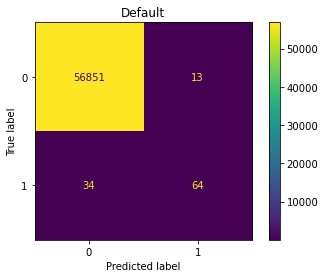

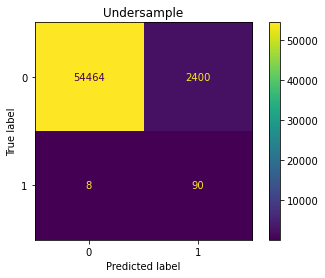

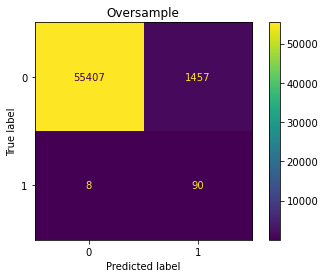

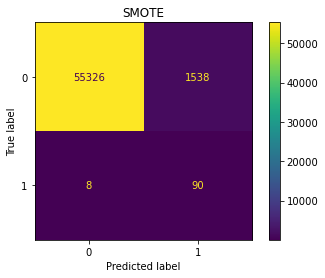

In [17]:
def_model, def_disp = create_confusion_plot(X_dev_scaled, X_test_scaled, y_dev, y_test, 'Default')
def_disp.plot()
plt.title('Default')
plt.show()
sub_model, sub_disp = create_confusion_plot(X_dev_sub, X_test_scaled, y_dev_sub, y_test, 'Subsample')
sub_disp.plot()
plt.title('Undersample')
plt.show()
ovs_model, ovs_disp = create_confusion_plot(X_dev_ovs, X_test_scaled, y_dev_ovs, y_test, 'Oversample')
ovs_disp.plot()
plt.title('Oversample')
plt.show()
sm_model, sm_disp = create_confusion_plot(X_dev_sm, X_test_scaled, y_dev_sm, y_test, 'SMOTE')
sm_disp.plot()
plt.title('SMOTE')
plt.show()

**Comments:**  
- Our default model produces the most amount of false negatives among the group, but vastly outperforms the other 3 sampling techniques on False Positives. This follows closesly to the techniques we are using to balance our datasets. We would expect our default model to have a relatively small number of false positives due to its lack of training on a more balanced dataset.
- I find it interesting that all of the balancing techniques had exactly 8 false negatives and 90 true positives. 

- If I had to choose a model in this situation, I would likely use the model from our oversampling technique. It wasn't too computationally heavy to fit, and resulted in the least number of false positives while still maintaining the highest precision.

**Plot the ROC for all four models above in a single plot.**

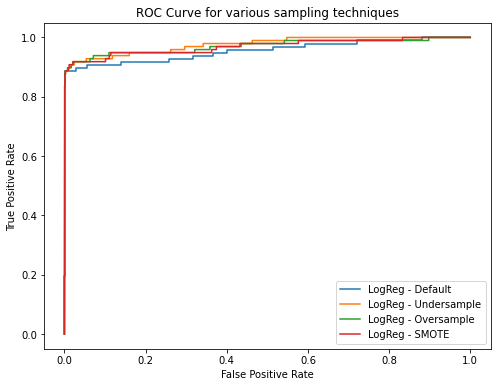

In [18]:
from sklearn.metrics import roc_curve

def_proba = def_model.predict_proba(X_test_scaled)
def_fpr, def_tpr, def_t = roc_curve(y_test.values, def_proba[:, 1])

sub_proba = sub_model.predict_proba(X_test_scaled)
sub_fpr, sub_tpr, sub_t = roc_curve(y_test.values, sub_proba[:, 1])

ovs_proba = ovs_model.predict_proba(X_test_scaled)
ovs_fpr, ovs_tpr, ovs_t = roc_curve(y_test.values, ovs_proba[:, 1])

sm_proba = sm_model.predict_proba(X_test_scaled)
sm_fpr, sm_tpr, sm_t = roc_curve(y_test.values, sm_proba[:, 1])


plt.figure(figsize=(8, 6))
plt.plot(def_fpr, def_tpr, label='LogReg - Default')
plt.plot(sub_fpr, sub_tpr, label='LogReg - Undersample')
plt.plot(ovs_fpr, ovs_tpr, label='LogReg - Oversample')
plt.plot(sm_fpr, sm_tpr, label='LogReg - SMOTE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for various sampling techniques')
plt.legend()
plt.show()

**Comments on ROC:**  
All of the models have a fairly similar area under the curve here, with SMOTE giving the highest AUC performance (based on values caluclated in earlier questions). We also see a clear lack of performance comparatively out of the default model, which we know has been trained on a highly imbalanced dataset.

**Plot the precision-recall curve for all four models above in a single plot.**

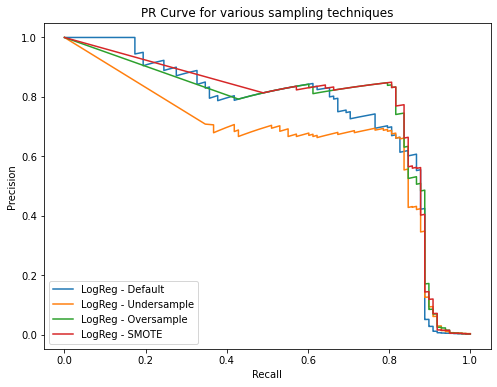

In [19]:
from sklearn.metrics import precision_recall_curve

def_proba = def_model.predict_proba(X_test_scaled)
def_p, def_r, def_t = precision_recall_curve(y_test.values, def_proba[:, 1])

sub_proba = sub_model.predict_proba(X_test_scaled)
sub_p, sub_r, sub_t = precision_recall_curve(y_test.values, sub_proba[:, 1])

ovs_proba = ovs_model.predict_proba(X_test_scaled)
ovs_p, ovs_r, ovs_t = precision_recall_curve(y_test.values, ovs_proba[:, 1])

sm_proba = sm_model.predict_proba(X_test_scaled)
sm_p, sm_r, sm_t = precision_recall_curve(y_test.values, sm_proba[:, 1])


plt.figure(figsize=(8, 6))
plt.plot(def_r, def_p, label='LogReg - Default')
plt.plot(sub_r, sub_p, label='LogReg - Undersample')
plt.plot(ovs_r, ovs_p, label='LogReg - Oversample')
plt.plot(sm_r, sm_p, label='LogReg - SMOTE')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for various sampling techniques')
plt.legend()
plt.show()

**Comments on PR Curve:**  
Here, using the methods of oversampling and SMOTE allow us to maintain relatively high precision as our recall gets closer to 1, allowing me to judge that they will yield the highest performance. Undersampling performs relatively pretty bad in the PR curve even compared to the default, which I believe is more than likely a consequence of a small training set when fitting.

**Adding class weights to a logistic regression model. Print the AUC and average precision of 5-fold cross validation. Also, plot its confusion matrix on test set.**

In [20]:
cw_scores = cross_validate(LogisticRegression(class_weight='balanced'), X_dev_scaled, y_dev, cv=5,
                            scoring=['roc_auc', 'average_precision'])
print('AUC: {}'.format(cw_scores['test_roc_auc'].mean()))
print('Avg. Precision: {}'.format(cw_scores['test_average_precision'].mean()))

AUC: 0.9806071364184955
Avg. Precision: 0.7521264537120119


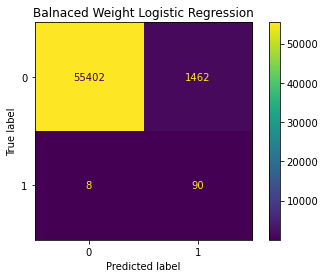

In [21]:
cw_model = LogisticRegression(class_weight='balanced').fit(X_dev_scaled, y_dev)
cw_cm = confusion_matrix(y_test, cw_model.predict(X_test_scaled), labels=cw_model.classes_)
cw_disp = ConfusionMatrixDisplay(confusion_matrix=cw_cm, display_labels=cw_model.classes_)
cw_disp.plot()
plt.title('Balnaced Weight Logistic Regression')
plt.show()

**Plot the ROC and the precision-recall curve for default Logistic without any sampling method and this balanced Logistic model in two single plots.**

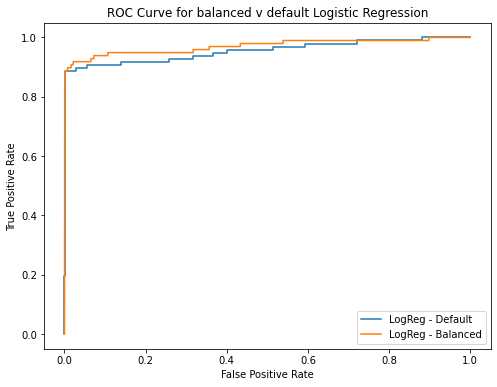

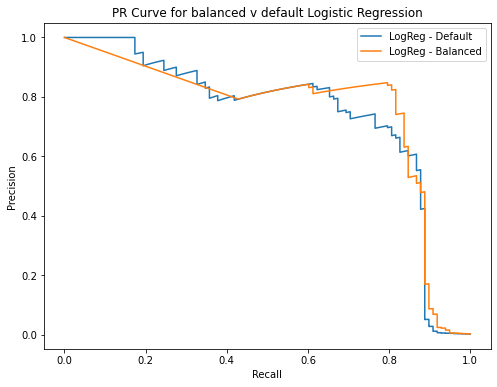

In [22]:
cw_proba = cw_model.predict_proba(X_test_scaled)
cw_fpr, cw_tpr, cw_t = roc_curve(y_test.values, cw_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(def_fpr, def_tpr, label='LogReg - Default')
plt.plot(cw_fpr, cw_tpr, label='LogReg - Balanced')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for balanced v default Logistic Regression')
plt.legend()
plt.show()

cw_p, cw_r, cw_t = precision_recall_curve(y_test.values, cw_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(def_r, def_p, label='LogReg - Default')
plt.plot(cw_r, cw_p, label='LogReg - Balanced')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for balanced v default Logistic Regression')
plt.legend()
plt.show()

**Comments:**  
We see from above that using balanced class weighting resulted in a model with better overall performance as seen from the two curves above, expeically the AUC from the ROC graph where performance difference is evident. our PR curve follows this up with a very solid precision/recall ration at around 0.8-0.8, heavily outperforming the default.

### Unsupervised Learning

In this part, we will be applying unsupervised learning approaches to a problem in computational biology. Specifically, we will be analyzing single-cell genomic sequencing data. Single-cell genomics is a set of revolutionary new technologies which can profile the genome of a specimen (tissue, blood, etc.) at the resolution of individual cells. This increased granularity can help capture intercellular heterogeneity, key to better understanding and treating complex genetic diseases such as cancer and Alzheimer's. 

<img src="https://cdn.10xgenomics.com/image/upload/v1574196658/blog/singlecell-v.-bulk-image.png" width="800px"/>

<center>Source: 10xgenomics.com/blog/single-cell-rna-seq-an-introductory-overview-and-tools-for-getting-started</center>

A common challenge of genomic datasets is their high-dimensionality: a single observation (a cell, in the case of single-cell data) may have tens of thousands of gene expression features. Fortunately, biology offers a lot of structure - different genes work together in pathways and are co-regulated by gene regulatory networks. Unsupervised learning is widely used to discover this intrinsic structure and prepare the data for further analysis.

### Dataset: single-cell RNASeq of mouse brain cells

Working with a single-cell RNASeq dataset of mouse brain cells. In the following gene expression matrix, each row represents a cell and each column represents a gene. Each entry in the matrix is a normalized gene expression count - a higher value means that the gene is expressed more in that cell. The dataset has been pre-processed using various quality control and normalization methods for single-cell data. 

In [23]:
cell_gene_counts_df = pd.read_csv('data/mouse_brain_cells_gene_counts.csv', index_col='cell')
cell_gene_counts_df

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253000,...,1.3150,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2.MAA000902.3_11_M.1.1,14.98400,1.1550,-0.576,-0.2727,-0.4153,0.7530,-0.4692,-0.03146,-0.6035,-1.021000,...,1.4260,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.728
E2.MAA000926.3_9_M.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.4720,-0.4692,-0.03146,1.8120,1.079000,...,-0.7227,-0.2145,-0.1927,-0.4163,0.2422,-0.5913,-0.553,1.6060,-0.04385,-0.681
E2.MAA000932.3_11_M.1.1,-0.08093,0.5703,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-0.003473,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,2.074


Note the dimensionality - we have 1000 cells (observations) and 18,585 genes (features)!

We are also provided a metadata file with annotations for each cell (e.g. cell type, subtissue, mouse sex, etc.)

In [24]:
cell_metadata_df = pd.read_csv('data/mouse_brain_cells_metadata.csv')
cell_metadata_df

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0
...,...,...,...,...,...,...,...,...
995,E2.MAA000902.3_11_M.1.1,astrocyte,Striatum,M,3_11_M,MAA000902,3026,3134463.0
996,E2.MAA000926.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000926,3085,744301.0
997,E2.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2277,519257.0
998,E2.MAA000944.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000944,3234,1437895.0


Different cell types

In [25]:
cell_metadata_df['cell_ontology_class'].value_counts()

oligodendrocyte                   385
endothelial cell                  264
astrocyte                         135
neuron                             94
brain pericyte                     58
oligodendrocyte precursor cell     54
Bergmann glial cell                10
Name: cell_ontology_class, dtype: int64

Different subtissue types (parts of the brain)

In [26]:
cell_metadata_df['subtissue'].value_counts()

Cortex         364
Hippocampus    273
Striatum       220
Cerebellum     143
Name: subtissue, dtype: int64

### 1 PCA

**Perform PCA and project the gene expression matrix onto its first 50 principal components. Using `sklearn.decomposition.PCA`.**

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [28]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=50))
components = pipe.fit_transform(cell_gene_counts_df)
print(components.shape)

(1000, 50)


**Plot the cumulative proportion of variance explained as a function of the number of principal components.**

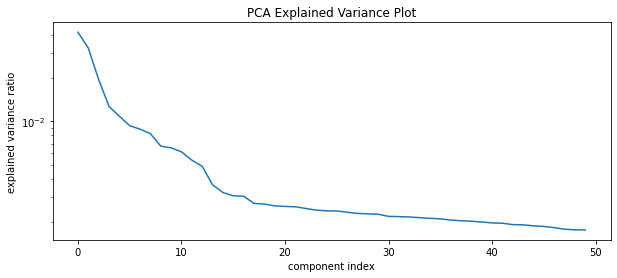


Total variance explained by first 20 components: 0.19405


In [29]:
pca_steps = pipe.named_steps['pca']
plt.figure(figsize=(10, 4))
plt.semilogy(pca_steps.explained_variance_ratio_)
plt.xlabel('component index')
plt.ylabel('explained variance ratio')
plt.title('PCA Explained Variance Plot')
plt.show()

print()
prop_var_20 = np.sum(pca_steps.explained_variance_ratio_[:20])
print('Total variance explained by first 20 components: {}'.format(np.around(prop_var_20, 5)))

**Top tem loadings and their gene names of first pca**

In [30]:
top_ten_args = np.flip(np.argsort(pca_steps.components_[0]))[:10]
cols = list(cell_gene_counts_df.columns)
print([(np.around(pca_steps.components_[0][i], 5), cols[i]) for i in top_ten_args])

[(0.02535, 'Ptpn5'), (0.02523, 'Nsg2'), (0.02508, 'D3Bwg0562e'), (0.02474, 'St8sia3'), (0.02464, 'Rtn1'), (0.02456, 'Bex2'), (0.02444, 'Hpca'), (0.02419, 'Snhg11'), (0.02419, 'Camk2b'), (0.02409, 'Atp1a3')]


**Plot the projection of the data onto the first two principal components using a scatter plot.**

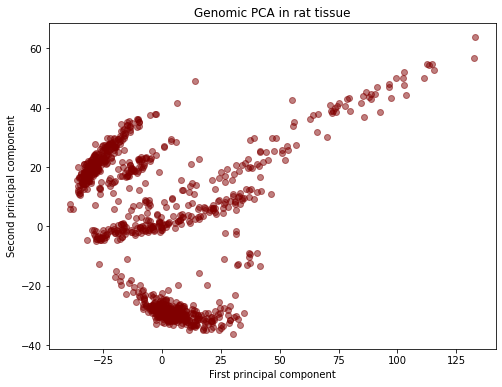

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c='maroon', alpha=0.5)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Genomic PCA in rat tissue')
plt.show()

**Now, use a small multiple of four scatter plots to make the same plot as above, but colored by four annotations in the metadata: cell_ontology_class, subtissue, mouse.sex, mouse.id.**

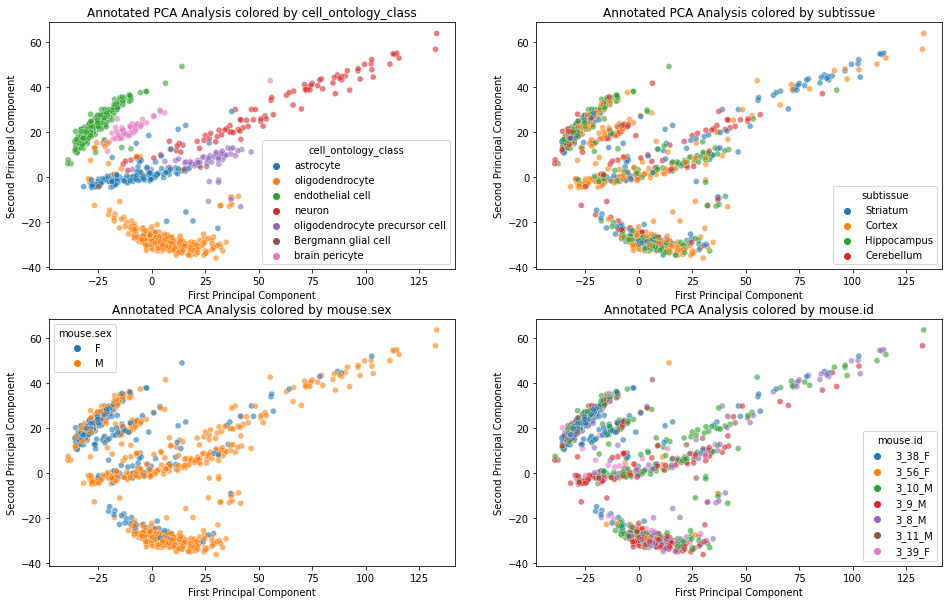

In [32]:
cats = ['cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id']
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for i in range(4):
    j = i // 2
    k = i % 2
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=cell_metadata_df[cats[i]], ax=ax[j, k], alpha=0.6)
    ax[j, k].set_xlabel('First Principal Component')
    ax[j, k].set_ylabel('Second Principal Component')
    ax[j, k].set_title('Annotated PCA Analysis colored by {}'.format(cats[i]))
plt.show()



Based on observation, it looks as though the cell ontology class is being described by the first two principal components. We see a heavy categorical grouping based on those classes, where the rest of the categories we chose to group by were not showing any strong groupings.

### 2 K-means

While the annotations provide high-level information on cell type (e.g. cell_ontology_class has 7 categories), we may also be interested in finding more granular subtypes of cells. To achieve this, we will use K-means clustering to find a large number of clusters in the gene expression dataset. Note that the original gene expression matrix had over 18,000 noisy features, which is not ideal for clustering. So, we will perform K-means clustering on the first 20 principal components of the dataset.

**Implement a `kmeans` function which takes in a dataset `X` and a number of clusters `k`, and returns the cluster assignment for each point in `X`.**

In [33]:
def kmeans(X, k, iters=10):
    '''Groups the points in X into k clusters using the K-means algorithm.

    Parameters
    ----------
    X : (m x n) data matrix
    k: number of clusters
    iters: number of iterations to run k-means loop

    Returns
    -------
    y: (m x 1) cluster assignment for each point in X
    '''
    dims = X.shape[1]
    clusters = [np.random.rand(dims) for i in range(k)]
    assignments = np.zeros(X.shape[0])
    # begin first iteration
    for iteration in range(iters):
        # find and update closest cluster for each point
        for i in range(X.shape[0]):
            short_dist = np.inf
            short_cluster = -1
            for cluster_no in range(len(clusters)):
                dist = np.linalg.norm(X[i] - clusters[cluster_no])
                if dist < short_dist:
                    short_dist = dist
                    short_cluster = cluster_no
            assignments[i] = short_cluster
        # update the center of each cluster
        for cluster_id in range(k):
            assigned = X[np.nonzero(assignments == cluster_id)[0]]
            clusters[cluster_id] = np.mean(assigned, axis=0)
    return assignments

Before applying K-means on the gene expression data, test it on synthetic dataset.

Text(0, 0.5, '$x_2$')

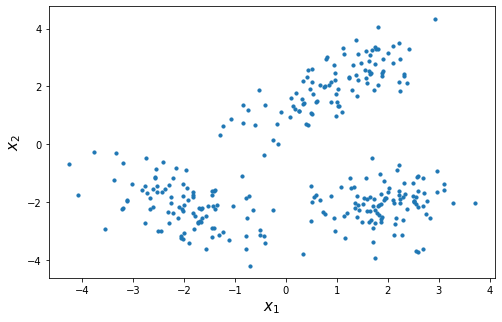

In [34]:
np.random.seed(0)
x_1 = np.random.multivariate_normal(mean=[1, 2], cov=np.array([[0.8, 0.6], [0.6, 0.8]]), size=100)
x_2 = np.random.multivariate_normal(mean=[-2, -2], cov=np.array([[0.8, -0.4], [-0.4, 0.8]]), size=100)
x_3 = np.random.multivariate_normal(mean=[2, -2], cov=np.array([[0.4, 0], [0, 0.4]]), size=100)
X = np.vstack([x_1, x_2, x_3])

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

**Apply K-means with k=3 to the synthetic dataset above.**

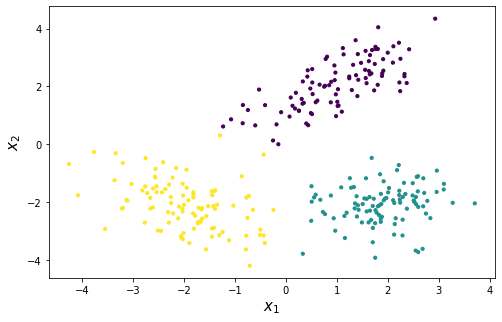

In [47]:
assignments = kmeans(X, k=3)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=assignments, s=10)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.show()

**Use K-means with k=20 to cluster the first 20 principal components of the gene expression data.**

In [42]:
first_20 = components[:, :20]
cluster_assignments = kmeans(first_20, k=20)
print('Number of cluster assignments: {}'.format(len(np.unique(cluster_assignments))))

Number of cluster assignments: 20


### 3 t-SNE

In this final section, we will visualize the data again using t-SNE - a non-linear dimensionality reduction algorithm. You can learn more about t-SNE in this interactive tutorial: https://distill.pub/2016/misread-tsne/.

**Use t-SNE to reduce the first 20 principal components of the gene expression dataset to two dimensions. Using `sklearn.manifold.TSNE`.**

In [37]:
perp = 40
embedded_20 = sklearn.manifold.TSNE(init='random', random_state=42, learning_rate='auto', perplexity=perp).fit_transform(first_20)

**Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions.**

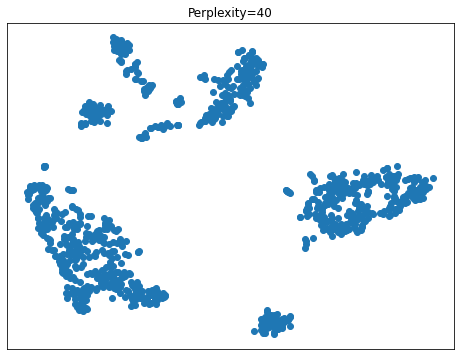

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(embedded_20[:, 0], embedded_20[:, 1])
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title("Perplexity={}".format(perp))
plt.show()

**Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions, with points colored by their cluster assignments.**

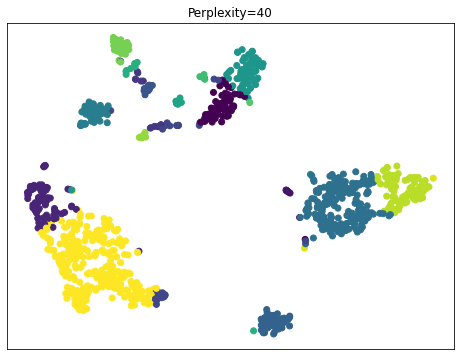

In [45]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded_20[:, 0], embedded_20[:, 1], c=cluster_assignments)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title("Perplexity={}".format(perp))
plt.show()

After doing some reading, it looks as though the density of our t-SNE clusters cannot be related to the clusters K Means found in higher dimensional space. My understanding is that we are offered a possible intuition of what groups are related to one another, but that doesnt necessarily mean they are related in a way such as euclidean distance from KMeans. This thought allows for overlap, as the tSNE dimensionality lowering may begin to descirbe as points that, although are similar to one another based on euclideant distance, may have patterns within the dimensions that closer match another subgroup.

These 20 clusters may correspond to various cell subtypes or cell states. They can be further investigated and mapped to known cell types based on their gene expressions (e.g. using the K-means cluster centers). The clusters may also be used in downstream analysis. For instance, we can monitor how the clusters evolve and interact with each other over time in response to a treatment.